In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split,cross_val_score
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from sklearn.impute import SimpleImputer, KNNImputer
import polars as pl
import lightgbm as lgbm
from lightgbm import LGBMClassifier, LGBMRegressor
import catboost as cb
from catboost import CatBoostClassifier, CatBoostRegressor
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import make_scorer, cohen_kappa_score
import torch
import torch.nn as nn
import torch.optim as optim
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
import seaborn as sns

%matplotlib inline


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

SEED = 42
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Version 17:
Thêm encoder cho dữ liệu time_series
Imputer các cột season trước bước drop dưới đây
Drop: các cột có nhiều hơn 50% giá trị thiếu -> đổi thành 30%
Chuyển đổi các giá trị Spring = 1, ...

# EDA

In [2]:
# Đọc dữ liệu
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sub_sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64


Text(0.5, 1.0, 'Count of sii')

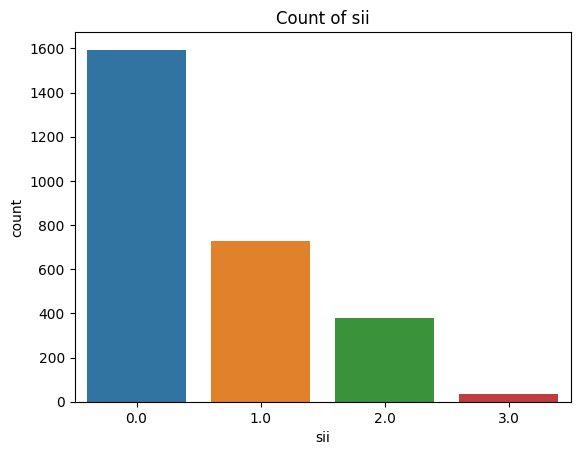

In [3]:
print(train.sii.value_counts())
sns.countplot(train, x = 'sii').set_title('Count of sii')

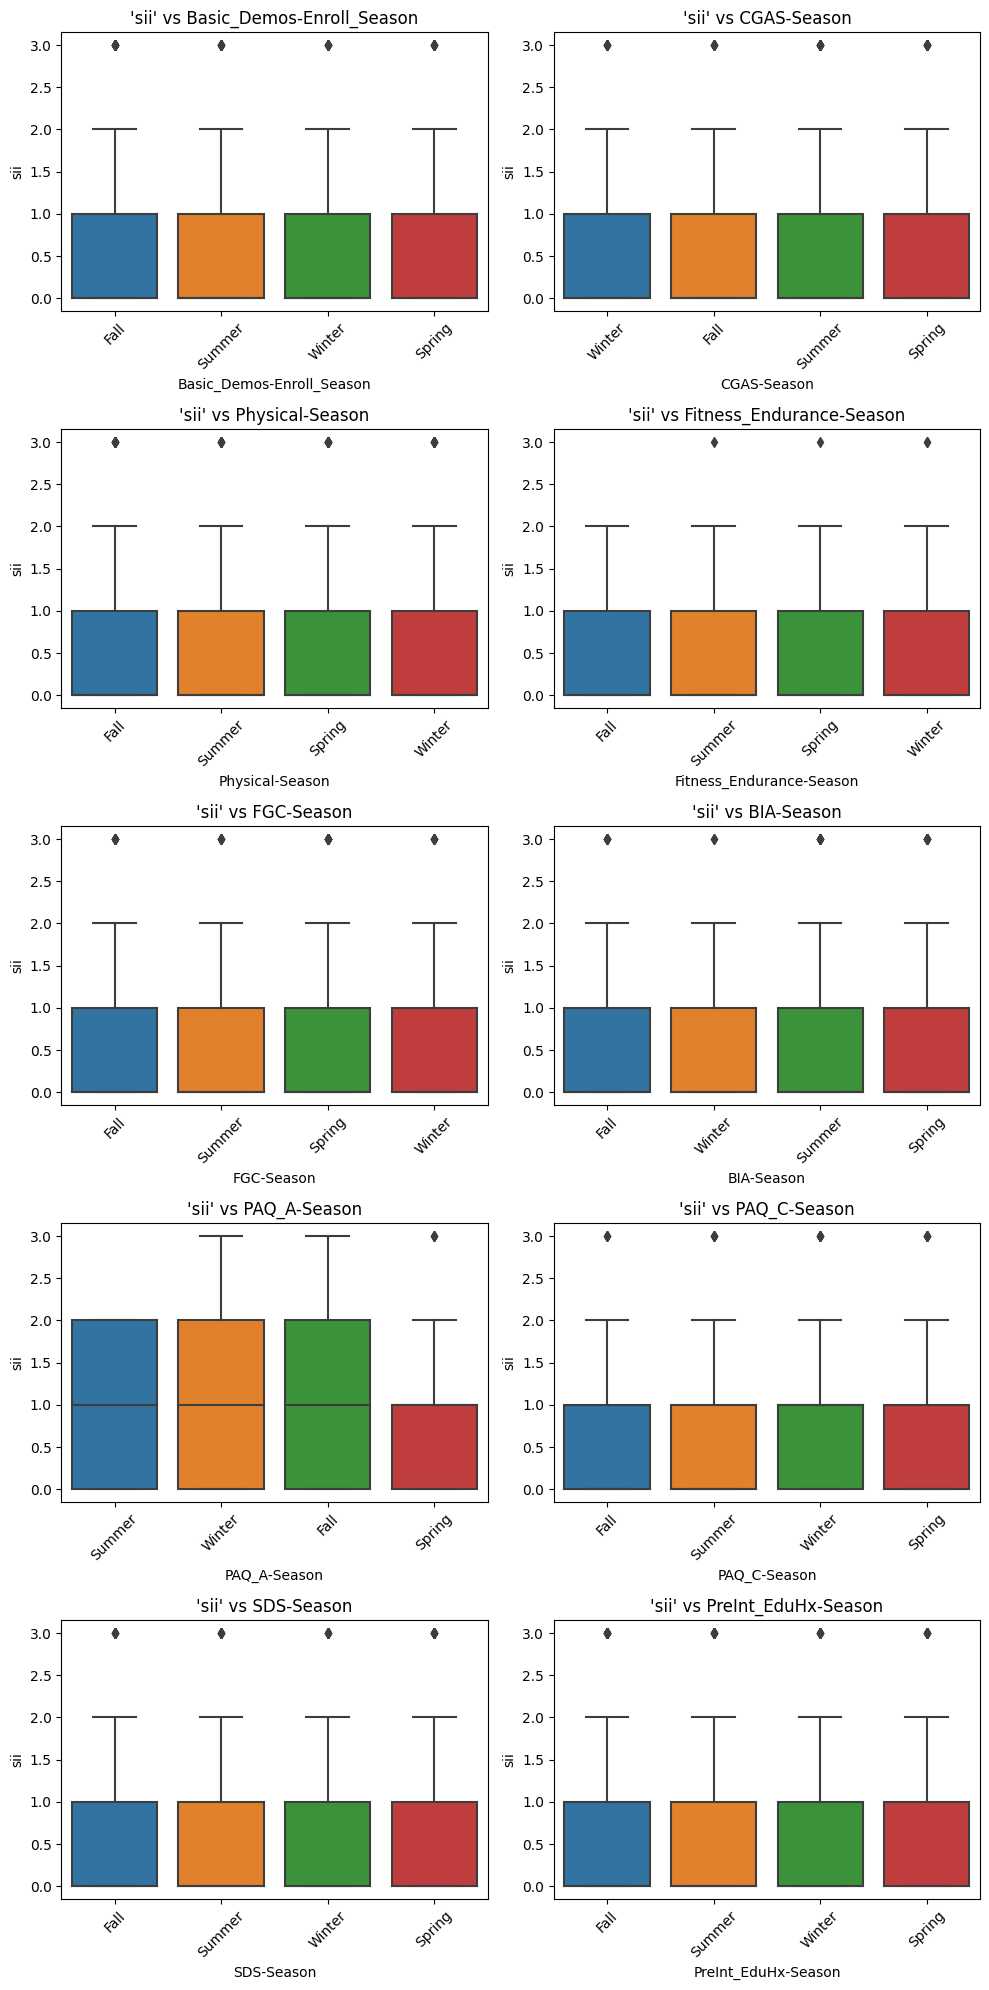

In [4]:
season_cols = [col for col in test if 'Season' in col]

plt.figure(figsize = (10,20))
for i, col in enumerate(season_cols, 1):
    plt.subplot(5, 2, i)  # 5 rows, 2 columns, plot i
    sns.boxplot(x=col, y='sii', data=train)
    plt.xticks(rotation = 45)
    plt.title(f"'sii' vs {col}")
plt.tight_layout()
plt.show()

In [5]:
# Xác suất các mùa
season_probabilities = train['Basic_Demos-Enroll_Season'].value_counts(normalize=True)
season_probabilities

Basic_Demos-Enroll_Season
Spring    0.284596
Winter    0.251768
Summer    0.244949
Fall      0.218687
Name: proportion, dtype: float64

In [6]:

print('Các cột bị thiếu trong test data:')
print([f for f in train.columns if f not in test.columns])

Các cột bị thiếu trong test data:
['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii']


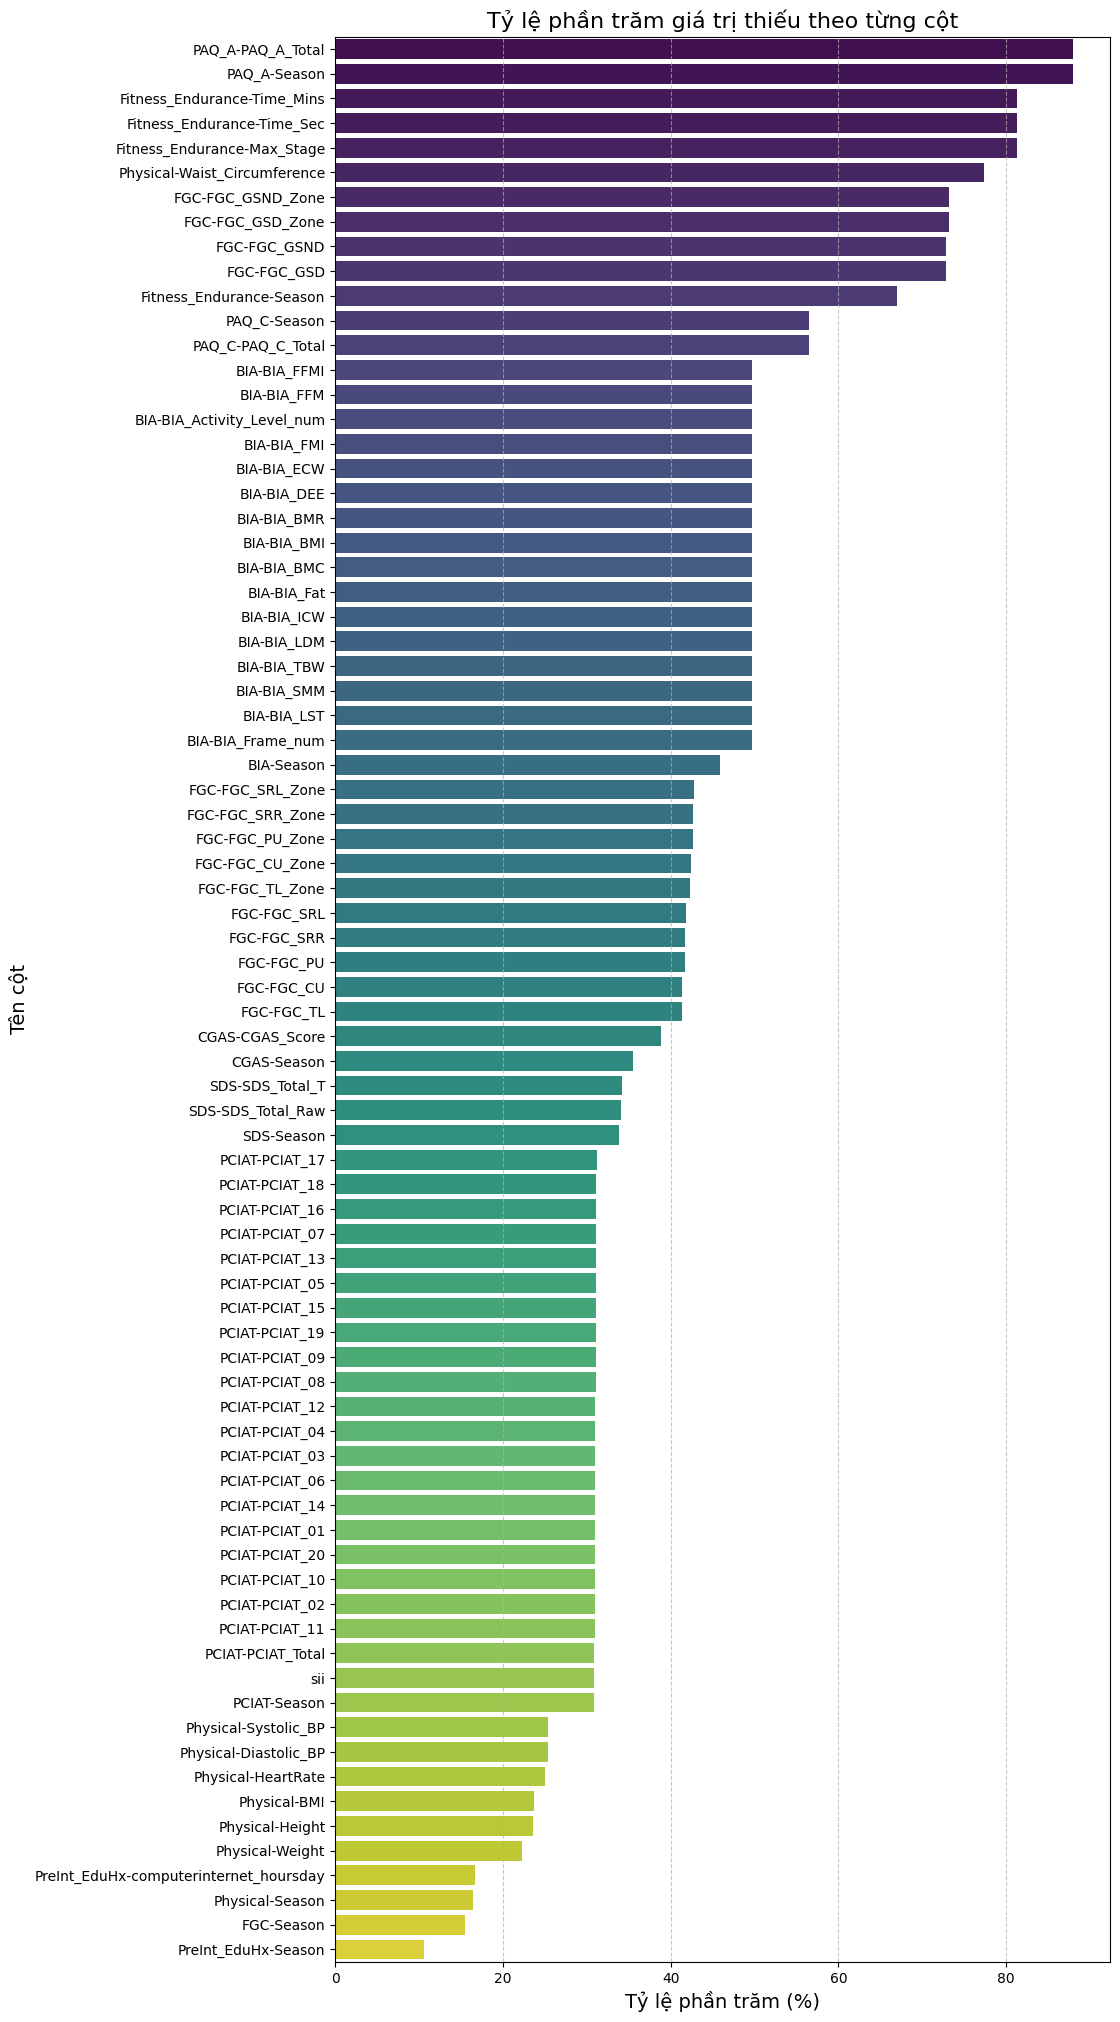

In [7]:
# Tính toán tỷ lệ phần trăm giá trị thiếu cho từng cột
missing_percentage = train.isnull().mean() * 100
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)  # Lọc các cột có giá trị thiếu

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 25))
sns.barplot(x=missing_percentage.values, y=missing_percentage.index, palette="viridis")
plt.title("Tỷ lệ phần trăm giá trị thiếu theo từng cột", fontsize=16)
plt.xlabel("Tỷ lệ phần trăm (%)", fontsize=14)
plt.ylabel("Tên cột", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

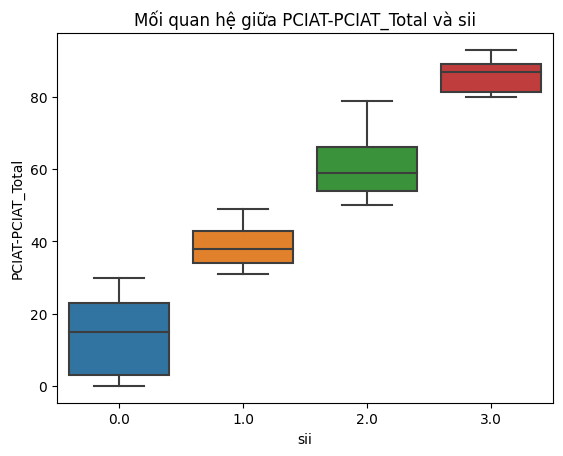

In [8]:
    sns.boxplot(x='sii', y='PCIAT-PCIAT_Total', data=train)
    plt.title(f'Mối quan hệ giữa PCIAT-PCIAT_Total và sii')
    plt.show()

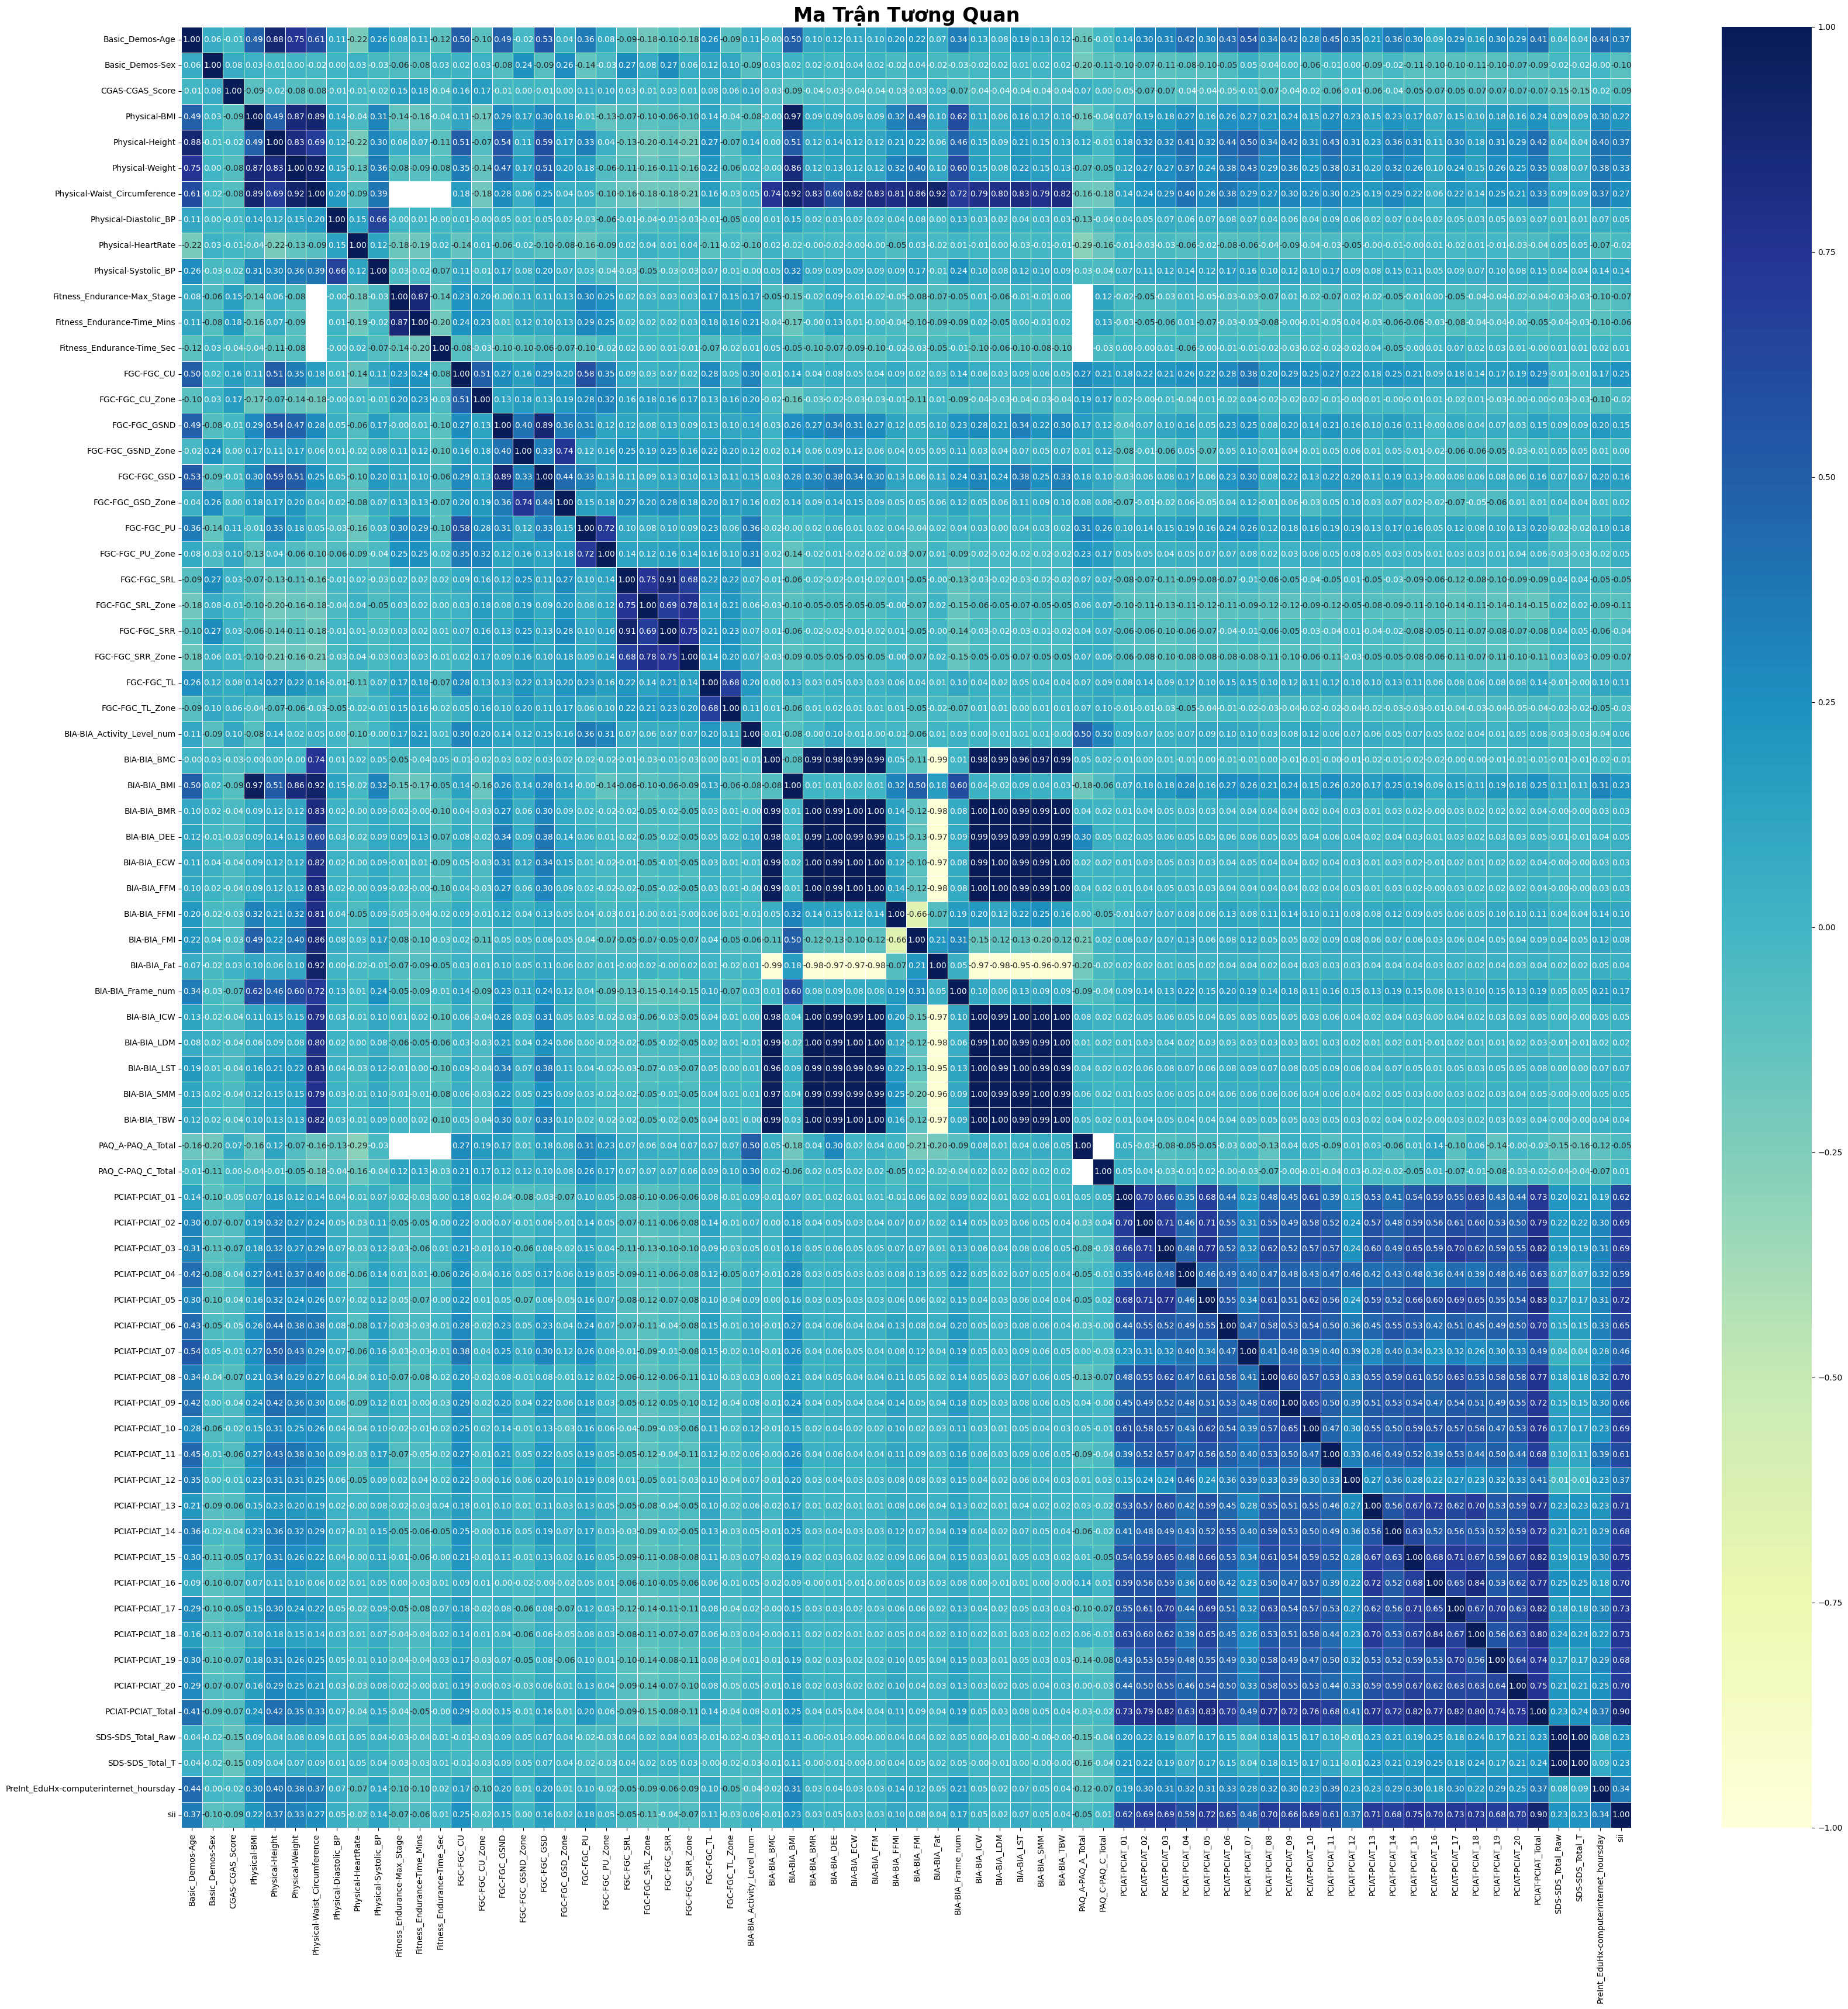

In [9]:
train_numeric = train.select_dtypes(include=['number'])

# Tính toán ma trận tương quan
corr_matrix = train_numeric.corr()

# Vẽ biểu đồ heatmap
plt.figure(figsize=(40, 40))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', linewidths=0.5, fmt='.2f', vmin=-1, vmax=1)
plt.title('Ma Trận Tương Quan', fontsize=24, weight='bold', color='black')
plt.show()

# Feature Engineering

In [10]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)

    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

def feature_engineering(df):
    # season_cols = [col for col in df.columns if 'Season' in col]
    # df = df.drop(season_cols, axis=1) 
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    
    return df

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim * 3), nn.ReLU(),
            nn.Linear(encoding_dim * 3, encoding_dim * 2), nn.ReLU(),
            nn.Linear(encoding_dim * 2, encoding_dim), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim * 2), nn.ReLU(),
            nn.Linear(input_dim * 2, input_dim * 3), nn.ReLU(),
            nn.Linear(input_dim * 3, input_dim), nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded




def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    data_tensor = torch.FloatTensor(df_scaled)
    
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())
    
    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i : i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')
                 
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()
        
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    
    return df_encoded

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   Basic_Demos-Enroll_Season               20 non-null     object 
 2   Basic_Demos-Age                         20 non-null     int64  
 3   Basic_Demos-Sex                         20 non-null     int64  
 4   CGAS-Season                             10 non-null     object 
 5   CGAS-CGAS_Score                         8 non-null      float64
 6   Physical-Season                         14 non-null     object 
 7   Physical-BMI                            13 non-null     float64
 8   Physical-Height                         13 non-null     float64
 9   Physical-Weight                         13 non-null     float64
 10  Physical-Waist_Circumference            5 non-null      float64


In [13]:
# Xử lý parquet thành các đặc trưng mới
train_ts_0 = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts_0 = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")


100%|██████████| 2/2 [00:00<00:00,  8.89it/s]


In [14]:
# test_ts.info()

In [15]:
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import torch.optim as optim

# Xử lý dữ liệu chuỗi thời gian

train_ts = train_ts_0.copy()
test_ts = test_ts_0.copy()
df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

train_ts_encoded = perform_autoencoder(df_train, encoding_dim=60, epochs=100, batch_size=32)
test_ts_encoded = perform_autoencoder(df_test, encoding_dim=60, epochs=100, batch_size=32)

time_series_cols = train_ts_encoded.columns.tolist()
train_ts_encoded["id"]=train_ts["id"]
test_ts_encoded['id']=test_ts["id"]

# Merge dữ liệu chuỗi thời gian vào train và test
train = pd.merge(train, train_ts_encoded, how="left", on='id')
test = pd.merge(test, test_ts_encoded, how="left", on='id')

test['sii'] = np.nan
test['PCIAT-PCIAT_Total'] = np.nan

train = feature_engineering(train)
train = train.dropna(thresh=10, axis=0)
test = feature_engineering(test)


Epoch [10/100], Loss: 1.6014]
Epoch [20/100], Loss: 1.5172]
Epoch [30/100], Loss: 1.5199]
Epoch [40/100], Loss: 1.4660]
Epoch [50/100], Loss: 1.3984]
Epoch [60/100], Loss: 1.3774]
Epoch [70/100], Loss: 1.3992]
Epoch [80/100], Loss: 1.3724]
Epoch [90/100], Loss: 1.3731]
Epoch [100/100], Loss: 1.3714]
Epoch [10/100], Loss: 0.9718]
Epoch [20/100], Loss: 0.4761]
Epoch [30/100], Loss: 0.4271]
Epoch [40/100], Loss: 0.4271]
Epoch [50/100], Loss: 0.4271]
Epoch [60/100], Loss: 0.4271]
Epoch [70/100], Loss: 0.4271]
Epoch [80/100], Loss: 0.4271]
Epoch [90/100], Loss: 0.4271]
Epoch [100/100], Loss: 0.4271]


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3371 entries, 0 to 3958
Columns: 157 entries, id to ICW_TBW
dtypes: float32(60), float64(83), int64(2), object(12)
memory usage: 3.3+ MB


In [17]:

# feature selection
featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
                'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'sii', 'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours',
                'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
                'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW', 'PCIAT-PCIAT_Total']

featuresCols += time_series_cols
featuresCols += season_cols

train = train.dropna(subset='sii')

# Loại bỏ các cột chứa >= 30% giá trị bị thiếu
cols_to_remove = [col for col in featuresCols if train[col].isnull().mean() >= 0.3]
featuresCols = [col for col in featuresCols if col not in cols_to_remove]

train = train[featuresCols]
test = test[featuresCols] # Đến bước này, train và test đang có các cột giống nhau
season_cols = [col for col in featuresCols if 'Season' in col] # List các cột season được giữ lại

# điền giá trị thiếu cho train data
imputer = KNNImputer(n_neighbors=5)
numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns
imputed_data = imputer.fit_transform(train[numeric_cols])
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)
train_imputed['sii'] = train_imputed['sii'].round().astype(int)

for col in train.columns:
    if col not in numeric_cols:
        train_imputed[col] = train[col]

train = train_imputed

# Điền giá trị thiếu cho các cột season trong train data
cat_cols = train.select_dtypes(include=['object']).columns
cat_imputer = SimpleImputer(strategy='most_frequent')
train[cat_cols] = cat_imputer.fit_transform(train[cat_cols])

# Chuyển giá trị season sang số nguyên
season_mapping = {'Spring': 1, 'Summer': 2, 'Fall': 3, 'Winter': 4}
for col in season_cols:
    train[col] = train[col].map(season_mapping)

# imputation cho test data (transform từ train data)
test[numeric_cols] = imputer.transform(test[numeric_cols])
test[cat_cols] = cat_imputer.transform(test[cat_cols])

# Chuyển giá trị season sang số nguyên
season_mapping = {'Spring': 1, 'Summer': 2, 'Fall': 3, 'Winter': 4}
for col in season_cols:
    test[col] = test[col].map(season_mapping)

test = test.drop('sii', axis=1)
test = test.drop('PCIAT-PCIAT_Total', axis=1) # Đến đây, train hơn test 2 cột 'sii' và 'PCIAT-PCIAT_TOTAL'

train.isna().sum()

Basic_Demos-Age                           0
Basic_Demos-Sex                           0
CGAS-CGAS_Score                           0
Physical-BMI                              0
Physical-Height                           0
Physical-Weight                           0
Physical-Diastolic_BP                     0
Physical-HeartRate                        0
Physical-Systolic_BP                      0
FGC-FGC_CU                                0
FGC-FGC_TL                                0
SDS-SDS_Total_Raw                         0
SDS-SDS_Total_T                           0
PreInt_EduHx-computerinternet_hoursday    0
sii                                       0
BMI_Age                                   0
Internet_Hours_Age                        0
BMI_Internet_Hours                        0
PCIAT-PCIAT_Total                         0
Basic_Demos-Enroll_Season                 0
CGAS-Season                               0
Physical-Season                           0
FGC-Season                      

In [18]:
test.isna().sum()

Basic_Demos-Age                           0
Basic_Demos-Sex                           0
CGAS-CGAS_Score                           0
Physical-BMI                              0
Physical-Height                           0
Physical-Weight                           0
Physical-Diastolic_BP                     0
Physical-HeartRate                        0
Physical-Systolic_BP                      0
FGC-FGC_CU                                0
FGC-FGC_TL                                0
SDS-SDS_Total_Raw                         0
SDS-SDS_Total_T                           0
PreInt_EduHx-computerinternet_hoursday    0
BMI_Age                                   0
Internet_Hours_Age                        0
BMI_Internet_Hours                        0
Basic_Demos-Enroll_Season                 0
CGAS-Season                               0
Physical-Season                           0
FGC-Season                                0
SDS-Season                                0
PreInt_EduHx-Season             

In [19]:
train.shape

(2736, 25)

In [20]:
train.isna().sum()

Basic_Demos-Age                           0
Basic_Demos-Sex                           0
CGAS-CGAS_Score                           0
Physical-BMI                              0
Physical-Height                           0
Physical-Weight                           0
Physical-Diastolic_BP                     0
Physical-HeartRate                        0
Physical-Systolic_BP                      0
FGC-FGC_CU                                0
FGC-FGC_TL                                0
SDS-SDS_Total_Raw                         0
SDS-SDS_Total_T                           0
PreInt_EduHx-computerinternet_hoursday    0
sii                                       0
BMI_Age                                   0
Internet_Hours_Age                        0
BMI_Internet_Hours                        0
PCIAT-PCIAT_Total                         0
Basic_Demos-Enroll_Season                 0
CGAS-Season                               0
Physical-Season                           0
FGC-Season                      

In [21]:
test.isna().sum()

Basic_Demos-Age                           0
Basic_Demos-Sex                           0
CGAS-CGAS_Score                           0
Physical-BMI                              0
Physical-Height                           0
Physical-Weight                           0
Physical-Diastolic_BP                     0
Physical-HeartRate                        0
Physical-Systolic_BP                      0
FGC-FGC_CU                                0
FGC-FGC_TL                                0
SDS-SDS_Total_Raw                         0
SDS-SDS_Total_T                           0
PreInt_EduHx-computerinternet_hoursday    0
BMI_Age                                   0
Internet_Hours_Age                        0
BMI_Internet_Hours                        0
Basic_Demos-Enroll_Season                 0
CGAS-Season                               0
Physical-Season                           0
FGC-Season                                0
SDS-Season                                0
PreInt_EduHx-Season             

In [22]:
df_train

,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,...,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,...,1.738203,5.314874,89.422226,0.0,2626.199951,4187.0,8.639500e+13,7.0,2.0,57.0
1,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,...,2.475326,3.966906,89.080330,1.0,2628.199951,4146.0,8.639500e+13,7.0,2.0,243.0
2,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,...,1.746797,5.066334,86.987267,0.0,2618.199951,4183.0,8.636500e+13,7.0,3.0,134.0
3,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,...,1.269051,6.134459,89.976074,0.0,2502.000000,6000.0,8.639500e+13,7.0,4.0,72.0
4,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,...,1.071875,2.774382,89.300034,0.0,1046.800049,4199.0,8.601500e+13,7.0,4.0,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,394128.0,394128.0,394128.0,394128.0,394128.0,394128.0,394128.0,394128.0,394128.0,394128.0,...,2.099614,3.669502,89.025551,1.0,2576.399902,4191.0,8.639500e+13,7.0,4.0,161.0
992,1195.0,1195.0,1195.0,1195.0,1195.0,1195.0,1195.0,1195.0,1195.0,1195.0,...,0.996484,1.786410,81.665283,0.0,1526.599976,4194.0,8.514000e+13,7.0,2.0,130.0
993,393240.0,393240.0,393240.0,393240.0,393240.0,393240.0,393240.0,393240.0,393240.0,393240.0,...,1.547813,3.692727,89.333710,1.0,2592.199951,4178.0,8.639500e+13,7.0,1.0,79.0
994,40085.0,40085.0,40085.0,40085.0,40085.0,40085.0,40085.0,40085.0,40085.0,40085.0,...,0.999219,1.673958,88.629547,0.0,1875.199951,4183.0,8.639500e+13,7.0,1.0,155.0


In [23]:
train

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-FGC_CU,...,BMI_Age,Internet_Hours_Age,BMI_Internet_Hours,PCIAT-PCIAT_Total,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,FGC-Season,SDS-Season,PreInt_EduHx-Season
0,5.0,0.0,51.0,16.877316,46.0,50.8,66.6,81.0,114.0,0.0,...,84.386578,15.0,50.631947,55.0,3,4,3,3,1,3
1,9.0,0.0,63.4,14.035590,48.0,46.0,75.0,70.0,122.0,3.0,...,126.320313,0.0,0.000000,0.0,2,1,3,3,3,2
2,10.0,1.0,71.0,16.648696,56.5,75.6,65.0,94.0,117.0,20.0,...,166.486961,20.0,33.297392,28.0,2,3,3,3,3,2
3,9.0,0.0,71.0,18.292347,56.0,81.6,60.0,97.0,117.0,18.0,...,164.631122,0.0,0.000000,44.0,4,3,2,2,2,4
4,13.0,1.0,50.0,22.279952,59.5,112.2,60.0,73.0,102.0,12.0,...,289.639376,0.0,0.000000,34.0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,8.0,0.0,70.8,17.139810,52.5,67.2,60.0,65.0,112.0,0.0,...,137.118476,16.0,34.279619,22.0,4,1,4,4,4,4
2732,7.0,1.0,57.4,13.927006,48.5,46.6,65.0,75.0,105.0,0.0,...,97.489042,0.0,0.000000,33.0,1,3,2,2,2,1
2733,13.0,0.0,60.0,16.362460,59.5,82.4,71.0,70.0,104.0,16.0,...,212.711984,13.0,16.362460,32.0,1,2,2,2,2,1
2734,11.0,0.0,68.0,21.441500,60.0,109.8,79.0,99.0,116.0,15.0,...,235.856500,0.0,0.000000,31.0,1,1,1,1,1,1


In [24]:
train.isna().sum()

Basic_Demos-Age                           0
Basic_Demos-Sex                           0
CGAS-CGAS_Score                           0
Physical-BMI                              0
Physical-Height                           0
Physical-Weight                           0
Physical-Diastolic_BP                     0
Physical-HeartRate                        0
Physical-Systolic_BP                      0
FGC-FGC_CU                                0
FGC-FGC_TL                                0
SDS-SDS_Total_Raw                         0
SDS-SDS_Total_T                           0
PreInt_EduHx-computerinternet_hoursday    0
sii                                       0
BMI_Age                                   0
Internet_Hours_Age                        0
BMI_Internet_Hours                        0
PCIAT-PCIAT_Total                         0
Basic_Demos-Enroll_Season                 0
CGAS-Season                               0
Physical-Season                           0
FGC-Season                      

In [25]:
train.columns.tolist()

['Basic_Demos-Age',
 'Basic_Demos-Sex',
 'CGAS-CGAS_Score',
 'Physical-BMI',
 'Physical-Height',
 'Physical-Weight',
 'Physical-Diastolic_BP',
 'Physical-HeartRate',
 'Physical-Systolic_BP',
 'FGC-FGC_CU',
 'FGC-FGC_TL',
 'SDS-SDS_Total_Raw',
 'SDS-SDS_Total_T',
 'PreInt_EduHx-computerinternet_hoursday',
 'sii',
 'BMI_Age',
 'Internet_Hours_Age',
 'BMI_Internet_Hours',
 'PCIAT-PCIAT_Total',
 'Basic_Demos-Enroll_Season',
 'CGAS-Season',
 'Physical-Season',
 'FGC-Season',
 'SDS-Season',
 'PreInt_EduHx-Season']

In [26]:
test.columns.tolist()

['Basic_Demos-Age',
 'Basic_Demos-Sex',
 'CGAS-CGAS_Score',
 'Physical-BMI',
 'Physical-Height',
 'Physical-Weight',
 'Physical-Diastolic_BP',
 'Physical-HeartRate',
 'Physical-Systolic_BP',
 'FGC-FGC_CU',
 'FGC-FGC_TL',
 'SDS-SDS_Total_Raw',
 'SDS-SDS_Total_T',
 'PreInt_EduHx-computerinternet_hoursday',
 'BMI_Age',
 'Internet_Hours_Age',
 'BMI_Internet_Hours',
 'Basic_Demos-Enroll_Season',
 'CGAS-Season',
 'Physical-Season',
 'FGC-Season',
 'SDS-Season',
 'PreInt_EduHx-Season']

In [27]:
train.dropna(subset = ["sii"], inplace = True)
train.isna().sum()

Basic_Demos-Age                           0
Basic_Demos-Sex                           0
CGAS-CGAS_Score                           0
Physical-BMI                              0
Physical-Height                           0
Physical-Weight                           0
Physical-Diastolic_BP                     0
Physical-HeartRate                        0
Physical-Systolic_BP                      0
FGC-FGC_CU                                0
FGC-FGC_TL                                0
SDS-SDS_Total_Raw                         0
SDS-SDS_Total_T                           0
PreInt_EduHx-computerinternet_hoursday    0
sii                                       0
BMI_Age                                   0
Internet_Hours_Age                        0
BMI_Internet_Hours                        0
PCIAT-PCIAT_Total                         0
Basic_Demos-Enroll_Season                 0
CGAS-Season                               0
Physical-Season                           0
FGC-Season                      

In [28]:
np.random.seed(42)

In [29]:
train.info

<bound method DataFrame.info of       Basic_Demos-Age  Basic_Demos-Sex  CGAS-CGAS_Score  Physical-BMI  \
0                 5.0              0.0             51.0     16.877316   
1                 9.0              0.0             63.4     14.035590   
2                10.0              1.0             71.0     16.648696   
3                 9.0              0.0             71.0     18.292347   
4                13.0              1.0             50.0     22.279952   
...               ...              ...              ...           ...   
2731              8.0              0.0             70.8     17.139810   
2732              7.0              1.0             57.4     13.927006   
2733             13.0              0.0             60.0     16.362460   
2734             11.0              0.0             68.0     21.441500   
2735             13.0              0.0             70.0     12.235895   

      Physical-Height  Physical-Weight  Physical-Diastolic_BP  \
0                46.0     

In [30]:
train.isna().sum()

Basic_Demos-Age                           0
Basic_Demos-Sex                           0
CGAS-CGAS_Score                           0
Physical-BMI                              0
Physical-Height                           0
Physical-Weight                           0
Physical-Diastolic_BP                     0
Physical-HeartRate                        0
Physical-Systolic_BP                      0
FGC-FGC_CU                                0
FGC-FGC_TL                                0
SDS-SDS_Total_Raw                         0
SDS-SDS_Total_T                           0
PreInt_EduHx-computerinternet_hoursday    0
sii                                       0
BMI_Age                                   0
Internet_Hours_Age                        0
BMI_Internet_Hours                        0
PCIAT-PCIAT_Total                         0
Basic_Demos-Enroll_Season                 0
CGAS-Season                               0
Physical-Season                           0
FGC-Season                      

In [31]:
test.isna().sum()

Basic_Demos-Age                           0
Basic_Demos-Sex                           0
CGAS-CGAS_Score                           0
Physical-BMI                              0
Physical-Height                           0
Physical-Weight                           0
Physical-Diastolic_BP                     0
Physical-HeartRate                        0
Physical-Systolic_BP                      0
FGC-FGC_CU                                0
FGC-FGC_TL                                0
SDS-SDS_Total_Raw                         0
SDS-SDS_Total_T                           0
PreInt_EduHx-computerinternet_hoursday    0
BMI_Age                                   0
Internet_Hours_Age                        0
BMI_Internet_Hours                        0
Basic_Demos-Enroll_Season                 0
CGAS-Season                               0
Physical-Season                           0
FGC-Season                                0
SDS-Season                                0
PreInt_EduHx-Season             

# Phân chia dữ liệu

In [32]:
# Chuẩn bị dữ liệu huấn luyện
com_columns = train.columns.intersection(test.columns).tolist()
X = train[com_columns]
y = train['PCIAT-PCIAT_Total']
X_test_1 = test[com_columns]

In [33]:
# Bảng quy đổi PCIAT-PCIAT_TOTAL sang sii
def convert(scores):
    scores = np.array(scores)*1.25
    pred = np.zeros_like(scores)
    pred[scores <= 30] = 0
    pred[(scores > 30) & (scores < 50)] = 1
    pred[(scores >= 50) & (scores < 80)] = 2
    pred[scores >= 80] = 3
    return pred

In [34]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, cohen_kappa_score

# Hàm kappa
def quadratic_kappa(y_true, y_pred):
    y_true_cat = convert(y_true)
    y_pred_cat = convert(y_pred)
    return cohen_kappa_score(y_true_cat, y_pred_cat, weights = 'quadratic')

# Scorer cho cross_val_score
kappa_scorer = make_scorer(quadratic_kappa, greater_is_better=True)

# Khởi tạo StratifiedKFold
skf = StratifiedKFold(n_splits=10)


# Cài đặt tham số

In [35]:
# Model parameters for LightGBM

Light_Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  # Increased from 6.59
    'lambda_l2': 0.01,  # Increased from 2.68e-06
    'device': 'cpu'

}

# XGBoost parameters
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased from 0.1
    'reg_lambda': 5,  # Increased from 1
    'random_state': 42,
    'tree_method': 'hist',

}

XGB_Params1 = {'max_depth': 3, 'n_estimators': 59, 'learning_rate': 0.07327652118259573, 'subsample': 0.5968194045365575, 'colsample_bytree': 0.9123669348125403}

# CatBoost parameters
CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': 42,
    'verbose': 0,
    'l2_leaf_reg': 15,  # Increase from 10
    'task_type': 'CPU'

}

# Tham số cho RF
RF_Params = {
    'n_estimators': 200,
    'max_depth': 6,
    'max_features': 0.8,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'bootstrap': True,
    'random_state': SEED
}

# Tham số cho GB
HistGB_Params = {
    'max_iter': 200, 
    'max_depth': 6,  
    'learning_rate': 0.5, 
    'loss': 'squared_error', 
    'max_leaf_nodes': None,  
    'random_state': SEED
}

# Model 1

có time_series, có season, PCIAT-PCIAT_Total -> sii
lgbm, xgb, catboost -> voting regressor

In [36]:
# Create model instances
Light = LGBMRegressor(**Light_Params, random_state = 42, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params1)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)

# Bước 2: Tạo Voting Regressor
voting_regressor = VotingRegressor(
    estimators=[
        ('lightgbm', Light),
        ('xgboost', XGB_Model),
        ('catboost', CatBoost_Model)
    ],
    weights=[4, 4, 5]  # Đặt trọng số cho từng mô hình
)

# Bước 3: Huấn luyện Voting Regressor
voting_regressor.fit(X, y)

# Bước 4: Dự đoán trên tập test
X_test_1 = test[com_columns]
ensemble_pred = voting_regressor.predict(X_test_1)

# Bước 5: Chuyển đổi dự đoán
y_test_1 = convert(ensemble_pred)
y_test_1 = np.round(y_test_1).astype(int)

# Bước 6: Tạo file submission
submission1 = sub_sample.copy()
submission1['sii'] = y_test_1


In [37]:
submission1

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,1
3,00115b9f,1
4,0016bb22,2
5,001f3379,1
6,0038ba98,1
7,0068a485,1
8,0069fbed,2
9,0083e397,2


In [38]:
# model_1 = xgb.XGBRegressor(**XGB_Params1)
# # Đánh giá mô hình
# scores = cross_val_score(model_1, X, y, cv=skf, scoring=kappa_scorer)
# print("Đánh giá mô hình XGBoost")
# print("QWK Scores:", scores)
# print("Mean QWK Score:", np.mean(scores))


# model_2 = cb.CatBoostRegressor(**CatBoost_Params)
# Đánh giá mô hình
# scores = cross_val_score(model_2, X, y, cv=skf, scoring=kappa_scorer)
# print("Đánh giá mô hình CatBoost")
# print("QWK Scores:", scores)
# print("Mean QWK Score:", np.mean(scores))

# model_3 = lgbm.LGBMRegressor(**Light_Params)
 # # Đánh giá mô hình
# scores = cross_val_score(model_3, X, y, cv=skf, scoring=kappa_scorer)
# print("Đánh giá mô hình LGBM")
# print("QWK Scores:", scores)
# print("Mean QWK Score:", np.mean(scores))

# Model 2

tương tự 1, nhưng ko time-series, có season, chuyển đổi PCIAT-PCIAT_Total -> sii,

thêm stacking cho ensemble

In [39]:
# Đọc dữ liệu
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

season_cols = [col for col in test.columns if 'Season' in col]

test['sii'] = np.nan
test['PCIAT-PCIAT_Total'] = np.nan

train = feature_engineering(train)
train = train.dropna(thresh=10, axis=0)
test = feature_engineering(test)

# feature selection
featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
                'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'sii', 'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours',
                'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
                'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW', 'PCIAT-PCIAT_Total']

featuresCols += season_cols

train = train.dropna(subset='sii')

# Loại bỏ các cột chứa >= 30% giá trị bị thiếu
cols_to_remove = [col for col in featuresCols if train[col].isnull().mean() >= 0.3]
featuresCols = [col for col in featuresCols if col not in cols_to_remove]

train = train[featuresCols]
test = test[featuresCols] # Đến bước này, train và test đang có các cột giống nhau
season_cols = [col for col in featuresCols if 'Season' in col] # List các cột season được giữ lại

# điền giá trị thiếu cho train data
imputer = KNNImputer(n_neighbors=5)
numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns
imputed_data = imputer.fit_transform(train[numeric_cols])
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)
train_imputed['sii'] = train_imputed['sii'].round().astype(int)

for col in train.columns:
    if col not in numeric_cols:
        train_imputed[col] = train[col]

train = train_imputed

# Điền giá trị thiếu cho các cột season trong train data
cat_cols = train.select_dtypes(include=['object']).columns
cat_imputer = SimpleImputer(strategy='most_frequent')
train[cat_cols] = cat_imputer.fit_transform(train[cat_cols])

# Chuyển giá trị season sang số nguyên
season_mapping = {'Spring': 1, 'Summer': 2, 'Fall': 3, 'Winter': 4}
for col in season_cols:
    train[col] = train[col].map(season_mapping)

# imputation cho test data (transform từ train data)
test[numeric_cols] = imputer.transform(test[numeric_cols])
test[cat_cols] = cat_imputer.transform(test[cat_cols])

# Chuyển giá trị season sang số nguyên
season_mapping = {'Spring': 1, 'Summer': 2, 'Fall': 3, 'Winter': 4}
for col in season_cols:
    test[col] = test[col].map(season_mapping)

test = test.drop('sii', axis=1)
test = test.drop('PCIAT-PCIAT_Total', axis=1) # Đến đây, train hơn test 2 cột 'sii' và 'PCIAT-PCIAT_TOTAL'

train.isna().sum()



Basic_Demos-Age                           0
Basic_Demos-Sex                           0
CGAS-CGAS_Score                           0
Physical-BMI                              0
Physical-Height                           0
Physical-Weight                           0
Physical-Diastolic_BP                     0
Physical-HeartRate                        0
Physical-Systolic_BP                      0
FGC-FGC_CU                                0
FGC-FGC_TL                                0
SDS-SDS_Total_Raw                         0
SDS-SDS_Total_T                           0
PreInt_EduHx-computerinternet_hoursday    0
sii                                       0
BMI_Age                                   0
Internet_Hours_Age                        0
BMI_Internet_Hours                        0
PCIAT-PCIAT_Total                         0
Basic_Demos-Enroll_Season                 0
CGAS-Season                               0
Physical-Season                           0
FGC-Season                      

In [40]:
# Đặt SEED
SEED = 42

# Bước 1: Khởi tạo các mô hình cơ bản với random_state=SEED
Light = LGBMRegressor(**Light_Params, random_state=SEED, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params1, random_state=SEED)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)

# Bước 2: Voting Regressor
voting_regressor = VotingRegressor(
    estimators=[
        ('lightgbm', Light),
        ('xgboost', XGB_Model),
        ('catboost', CatBoost_Model)
    ],
    weights=[4, 4, 5]  # Đặt trọng số cho từng mô hình
)

# Bước 3: Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=[
        ('lightgbm', Light),
        ('xgboost', XGB_Model),
        ('catboost', CatBoost_Model)
    ],
    final_estimator=Ridge(alpha=1.0, random_state=SEED),  # Meta-learner với random_state
    cv=5  # Cross-validation
)

# Bước 4: Kết hợp cả hai ensemble vào mô hình Stacking Regressor cuối cùng
final_ensemble = StackingRegressor(
    estimators=[
        ('voting', voting_regressor),
        ('stacking', stacking_regressor)
    ],
    final_estimator=Ridge(alpha=0.5, random_state=SEED),  # Meta-learner cuối cùng
    cv=5  # Cross-validation
)

# Bước 5: Huấn luyện mô hình cuối cùng
final_ensemble.fit(X, y)

# Bước 6: Dự đoán trên tập test
final_pred = final_ensemble.predict(X_test_1)

# Bước 7: Chuyển đổi dự đoán
y_test_final = convert(final_pred)
y_test_final = np.round(y_test_final).astype(int)

# Bước 8: Tạo file submission
submission_2 = sub_sample.copy()
submission_2['sii'] = y_test_final


In [41]:
submission_2

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,1
3,00115b9f,1
4,0016bb22,2
5,001f3379,1
6,0038ba98,1
7,0068a485,1
8,0069fbed,2
9,0083e397,2


In [42]:
submission_2.to_csv('submission.csv', index=False)

# Model 3

Có time_series, ko season, dự đoán trực tiếp sii
Thêm Random Forest, Gradient Boost

In [43]:
# Đọc dữ liệu
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sub_sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

# Xử lý parquet thành các đặc trưng mới
train_ts = train_ts_0.copy()
test_ts = test_ts_0.copy()

from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import torch.optim as optim

# Xử lý dữ liệu chuỗi thời gian
df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

train_ts_encoded = perform_autoencoder(df_train, encoding_dim=60, epochs=100, batch_size=32)
test_ts_encoded = perform_autoencoder(df_test, encoding_dim=60, epochs=100, batch_size=32)

time_series_cols = train_ts_encoded.columns.tolist()
train_ts_encoded["id"]=train_ts["id"]
test_ts_encoded['id']=test_ts["id"]

# Merge dữ liệu chuỗi thời gian vào train và test
train = pd.merge(train, train_ts_encoded, how="left", on='id')
test = pd.merge(test, test_ts_encoded, how="left", on='id')

test['sii'] = np.nan
test['PCIAT-PCIAT_Total'] = np.nan

train = feature_engineering(train)
train = train.dropna(thresh=10, axis=0)
test = feature_engineering(test)

# feature selection
featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
                'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'sii', 'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours',
                'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
                'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW']

featuresCols += time_series_cols

train = train.dropna(subset='sii')

# Loại bỏ các cột chứa >= 30% giá trị bị thiếu
cols_to_remove = [col for col in featuresCols if train[col].isnull().mean() >= 0.3]
featuresCols = [col for col in featuresCols if col not in cols_to_remove]

train = train[featuresCols]
test = test[featuresCols] # Đến bước này, train và test đang có các cột giống nhau

# điền giá trị thiếu cho train data
imputer = KNNImputer(n_neighbors=5)
numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns
imputed_data = imputer.fit_transform(train[numeric_cols])
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)
train_imputed['sii'] = train_imputed['sii'].round().astype(int)

for col in train.columns:
    if col not in numeric_cols:
        train_imputed[col] = train[col]

train = train_imputed

# imputation cho test data (transform từ train data)
test[numeric_cols] = imputer.transform(test[numeric_cols])

test = test.drop('sii', axis=1) # Đến đây, train hơn test 1 cột là 'sii'

train.isna().sum()


Epoch [10/100], Loss: 1.5012]
Epoch [20/100], Loss: 1.4401]
Epoch [30/100], Loss: 1.4082]
Epoch [40/100], Loss: 1.4018]
Epoch [50/100], Loss: 1.3990]
Epoch [60/100], Loss: 1.4036]
Epoch [70/100], Loss: 1.4097]
Epoch [80/100], Loss: 1.3960]
Epoch [90/100], Loss: 1.3926]
Epoch [100/100], Loss: 1.3757]
Epoch [10/100], Loss: 1.0073]
Epoch [20/100], Loss: 0.6446]
Epoch [30/100], Loss: 0.4273]
Epoch [40/100], Loss: 0.4271]
Epoch [50/100], Loss: 0.4271]
Epoch [60/100], Loss: 0.4271]
Epoch [70/100], Loss: 0.4271]
Epoch [80/100], Loss: 0.4271]
Epoch [90/100], Loss: 0.4271]
Epoch [100/100], Loss: 0.4271]


Basic_Demos-Age                           0
Basic_Demos-Sex                           0
CGAS-CGAS_Score                           0
Physical-BMI                              0
Physical-Height                           0
Physical-Weight                           0
Physical-Diastolic_BP                     0
Physical-HeartRate                        0
Physical-Systolic_BP                      0
FGC-FGC_CU                                0
FGC-FGC_TL                                0
SDS-SDS_Total_Raw                         0
SDS-SDS_Total_T                           0
PreInt_EduHx-computerinternet_hoursday    0
sii                                       0
BMI_Age                                   0
Internet_Hours_Age                        0
BMI_Internet_Hours                        0
dtype: int64

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 18 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Age                         2736 non-null   float64
 1   Basic_Demos-Sex                         2736 non-null   float64
 2   CGAS-CGAS_Score                         2736 non-null   float64
 3   Physical-BMI                            2736 non-null   float64
 4   Physical-Height                         2736 non-null   float64
 5   Physical-Weight                         2736 non-null   float64
 6   Physical-Diastolic_BP                   2736 non-null   float64
 7   Physical-HeartRate                      2736 non-null   float64
 8   Physical-Systolic_BP                    2736 non-null   float64
 9   FGC-FGC_CU                              2736 non-null   float64
 10  FGC-FGC_TL                              2736 non-null   floa

In [45]:
# Chuẩn bị dữ liệu huấn luyện
com_columns = train.columns.intersection(test.columns).tolist()
X = train[com_columns]
y = train["sii"]
X_test_1 = test[com_columns]

In [46]:
# Đặt SEED
SEED = 42

# Bước 1: Khởi tạo các mô hình với tham số đã tối ưu
Light = LGBMRegressor(**Light_Params, random_state=SEED, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params1, random_state=SEED)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)
RF_Model = RandomForestRegressor(**RF_Params)
GB_Model = HistGradientBoostingRegressor(**HistGB_Params)


# Bước 2: Tạo Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=[
        ('lightgbm', Light),
        ('xgboost', XGB_Model),
        ('catboost', CatBoost_Model),
        ('random_forest', RF_Model),
        ('hist_gb', GB_Model)
    ],
    final_estimator=Ridge(alpha=1.0, random_state=SEED),  # Meta-learner
    cv=5  # Cross-validation
)

# Bước 3: Huấn luyện Stacking Regressor
stacking_regressor.fit(X, y)

# Bước 4: Dự đoán trên tập test
stacking_pred = stacking_regressor.predict(X_test_1)

# Bước 5: Làm tròn
y_test_final = np.round(stacking_pred).astype(int)

# Bước 6: Tạo submission
submission_3 = sub_sample.copy()
submission_3['sii'] = y_test_final


In [47]:
submission_3

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,1
7,0068a485,0
8,0069fbed,1
9,0083e397,1


# Result

In [48]:
# # Bỏ phiếu đa số
# submission1 = submission1.sort_values(by='id').reset_index(drop=True)
# submission2 = submission_2.sort_values(by='id').reset_index(drop=True)
# submission3 = submission_3.sort_values(by='id').reset_index(drop=True)

# combined = pd.DataFrame({
#     'id': submission1['id'],
#     'sii_1': submission1['sii'],
#     'sii_2': submission2['sii'],
#     'sii_3': submission3['sii']
# })

# def majority_vote(row):
#    return row.mode()[0]

# combined['final_sii'] = combined[['sii_1', 'sii_2', 'sii_3']].apply(majority_vote, axis=1)

# final_submission = combined[['id', 'final_sii']].rename(columns={'final_sii': 'sii'})
# final_submission.to_csv('submission.csv', index=False)

In [49]:
# final_submission